<a href="https://www.kaggle.com/code/chaturadevinda/cat-and-dog-classifier-with-tranfer-lerning?scriptVersionId=186635797" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
#import necessary libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

In [5]:
train_data_dir = "/kaggle/input/cats-and-dogs-for-classification/cats_dogs/train"
test_data_dir = "/kaggle/input/cats-and-dogs-for-classification/cats_dogs/test"

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size = BATCH_SIZE,
                                                         image_size = IMAGE_SIZE,
                                                         subset = 'training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size = BATCH_SIZE,
                                                         image_size = IMAGE_SIZE,
                                                         subset = 'validation',
                                                         validation_split=0.1,
                                                         seed=42)
test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size = BATCH_SIZE,
                                                         image_size = IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [7]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [8]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 128, 128, 3)
(32,)


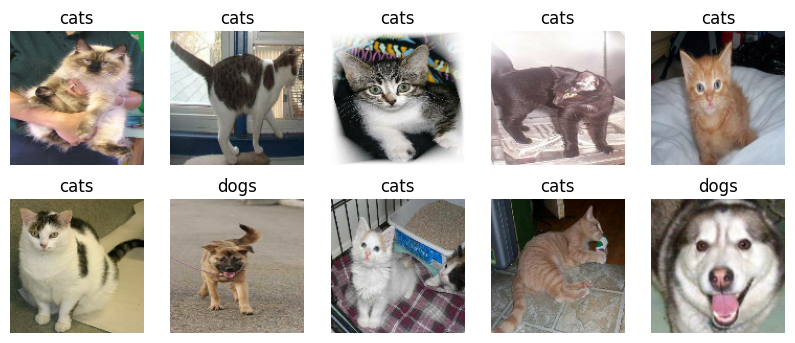

In [9]:
#plot data samples
plt.figure(figsize=(10,4))
for image, label in train_data.take(2):
  for i in range(10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(class_names[label[i]])
    plt.axis('off')

In [10]:
train_data = train_data.map(lambda x,y: (x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255, y))
test_data = test_data.map(lambda x,y: (x/255, y))

In [11]:
pretrained_model = tf.keras.applications.xception.Xception(include_top=False,
                                                           input_shape=(128,128,3),
                                                           weights="imagenet",
                                                           pooling='max')


for layer in pretrained_model.layers:
  layer.trainable=False

83683744/83683744 [==============================] - 0s 0us/step


In [12]:
model = tf.keras.models.Sequential()

model.add(pretrained_model)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21144425 (80.66 MB)
Trainable params: 2829

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [15]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=5,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/5


I0000 00:00:1719988246.082697     223 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 [==============================] - 19s 51ms/step - loss: 0.1617 - accuracy: 0.9333 - val_loss: 0.1019 - val_accuracy: 0.9550
Epoch 2/5
225/225 [==============================] - 10s 46ms/step - loss: 0.1175 - accuracy: 0.9508 - val_loss: 0.1114 - val_accuracy: 0.9500
Epoch 3/5
225/225 [==============================] - 10s 46ms/step - loss: 0.0982 - accuracy: 0.9603 - val_loss: 0.1105 - val_accuracy: 0.9588
Epoch 4/5
225/225 [==============================] - 11s 46ms/step - loss: 0.0845 - accuracy: 0.9658 - val_loss: 0.1344 - val_accuracy: 0.9425
Epoch 5/5
225/225 [==============================] - 11s 46ms/step - loss: 0.0717 - accuracy: 0.9714 - val_loss: 0.1177 - val_accuracy: 0.9550


In [16]:
model.save('/kaggle/working/model/cat_and_dog.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


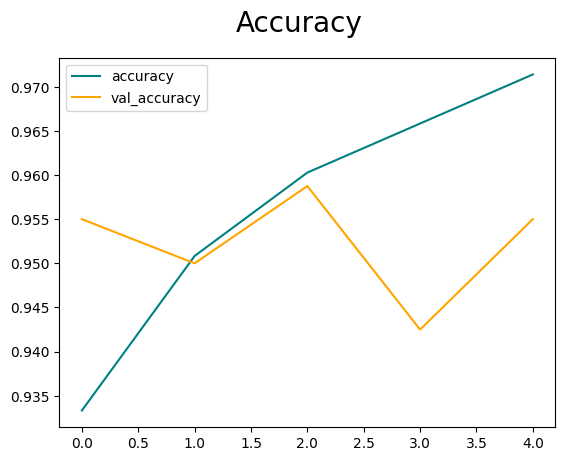

In [17]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

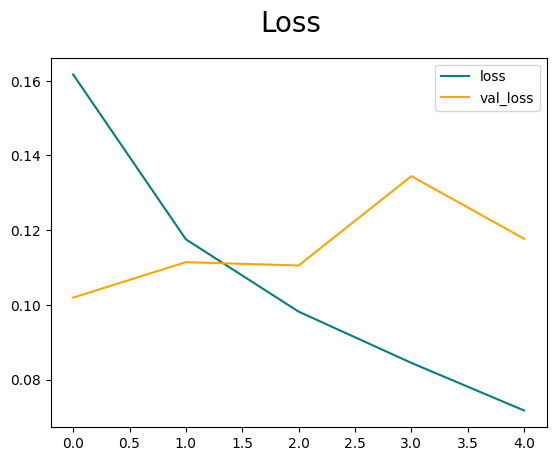

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()

In [19]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.metrics.BinaryAccuracy()

In [20]:
for batch in test_data.as_numpy_iterator():
  X,Y = batch
  yhat = model.predict(X)
  precision.update_state(Y, yhat)
  recall.update_state(Y,yhat)
  accuracy.update_state(Y,yhat)

1/1 [==============================] - 2s 2s/step


In [21]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.93417233>

In [22]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.965>

In [23]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9485>

In [24]:
!pip install opencv-python

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [25]:
import cv2

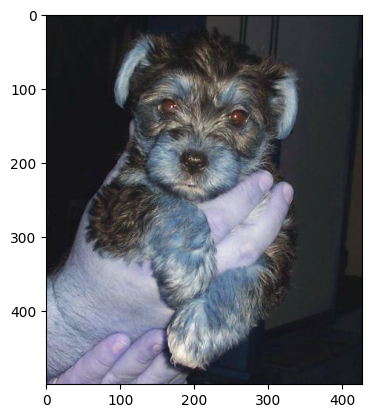

In [26]:
image = cv2.imread('/kaggle/input/cats-and-dogs-for-classification/cats_dogs/test/dogs/dog.4002.jpg')
plt.imshow(image)
plt.show()

In [27]:
resized_image = tf.image.resize(image, IMAGE_SIZE)
scaled_image = resized_image/255

In [28]:
np.expand_dims(scaled_image, 0).shape

(1, 128, 128, 3)

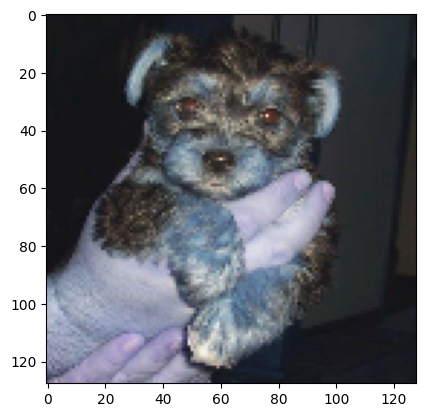

In [29]:
plt.imshow(scaled_image)
plt.show()

In [30]:
y_hat = model.predict(np.expand_dims(scaled_image, 0))

1/1 [==============================] - 1s 804ms/step


In [31]:
y_hat

array([[0.676888]], dtype=float32)

In [32]:
if y_hat >= 0.5:
  print(class_names[1])
else:
  print(class_names[0])

dogs
